# EDA

In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 67.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.6/920.6 kB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 92.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 50.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

First, let's concatenate all corpora to one dataframe (assuming that this notebook is placed within *lecture_data* folder downloaded from Teams channel):

In [4]:
data_directory = 'data/'
dfs = []

for i in range(1, 5):
    file_path = os.path.join(data_directory, f'corpus{i}', 'train.txt')
    df_i = pd.read_csv(file_path, sep=' ', header=None, names=['word', 'entity'])
    df_i['corpus_index'] = i
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna()

Here we load a model for embeddings:

In [5]:
nlp = spacy.load("en_core_web_md")

Some additional functions used in analysis:

In [6]:
def get_word_embedding(word):
    return nlp(word).vector

def get_top_words_for_entity_type(df, entity_type, top_n=5):
    entity_words = df[df['entity_type'] == entity_type]['word']
    top_words = entity_words.value_counts().head(top_n).index.tolist()
    return top_words

def plot_top_words_for_entity_types(df, entity_types, top_n=5):
    plt.figure(figsize=(15, 10))

    for i, entity_type in enumerate(entity_types, 1):
        plt.subplot(2, 3, i)
        top_words = get_top_words_for_entity_type(df, entity_type, top_n)
        sns.countplot(y='word', data=df[df['word'].isin(top_words)], order=top_words, palette='viridis')
        plt.title(f'Top {top_n} Words for {entity_type}')

    plt.tight_layout()
    plt.show()

def compute_similarity_matrix(words1, words2):
    word_embeddings1 = [get_word_embedding(word) for word in words1]
    word_embeddings2 = [get_word_embedding(word) for word in words2]
    similarity_matrix = cosine_similarity(word_embeddings1, word_embeddings2)
    return similarity_matrix

def plot_similarity_heatmap(words1, words2, similarity_matrix):
    plt.figure(figsize=(8, 8))
    sns.heatmap(similarity_matrix, annot=True, xticklabels=words2, yticklabels=words1, cmap='Blues')
    plt.title('Cosine Similarity Heatmap between Entity Types')
    plt.show()

def measure_similarity_between_entity_types(df, entity_types):
    entity_words = {entity_type: df[df['entity_type'] == entity_type]['word'].tolist() for entity_type in entity_types}
    similarity_matrix = np.zeros((len(entity_types), len(entity_types)))

    for i, entity_type1 in enumerate(entity_types):
        for j, entity_type2 in enumerate(entity_types):
            similarity_matrix[i, j] = np.mean(compute_similarity_matrix(entity_words[entity_type1], entity_words[entity_type2]))

    plot_similarity_heatmap(entity_types, entity_types, similarity_matrix)

Main analysis function:

In [7]:
def analyse(df):
    df['is_entity'] = df['entity'].apply(lambda x: False if x == 'O' else True)
    df['is_start'] = df['entity'].apply(lambda x: True if x.count('B-') == 1 else False)
    df['entity_type'] = df['entity'].apply(lambda x: x.split('-')[1] if x.count('-') == 1 else None)

    entity_counts = df['is_entity'].value_counts()
    entity_type_percentage = entity_counts / entity_counts.sum() * 100
    
    # words distribution
    plt.pie(entity_counts, labels=['other', 'entity'], autopct='%1.1f%%', colors=['#FF9999', 'skyblue'])
    plt.title('Words distribution')
    plt.show()

    # entities distribution
    entity_start_counts = df[df['is_start'] & df['is_entity']]['entity_type'].value_counts()
    sns.barplot(x=entity_start_counts.index, y=entity_start_counts.values, palette='viridis')
    plt.xlabel('type')
    plt.ylabel('count')
    plt.title('Distribution of entities')
    plt.show()

    # entity lengths distribution
    df['entity_length'] = df.groupby((df['entity_type'] != df['entity_type'].shift(1)).cumsum())['word'].transform('count')
    sns.boxplot(x='entity_type', y='entity_length', data=df[df['is_entity']], palette='muted')
    plt.xlabel('type')
    plt.ylabel('length')
    plt.title('Length of entities per type')
    plt.show()

    # cosine similarity between entities
    entity_types = df[df['entity_type'].notnull()]['entity_type'].unique()
    measure_similarity_between_entity_types(df, entity_types)

    # 5 most frequent words for each entity
    plot_top_words_for_entity_types(df, entity_types, top_n=5)

Let's see the results (warning: cosine similarity takes few minute to compute):

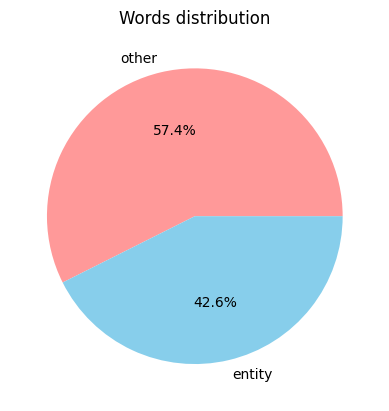

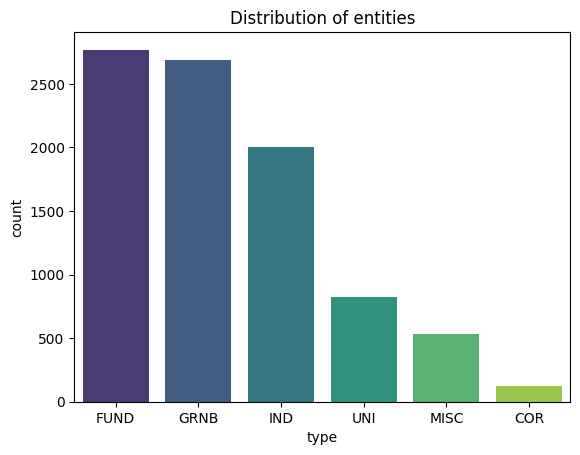

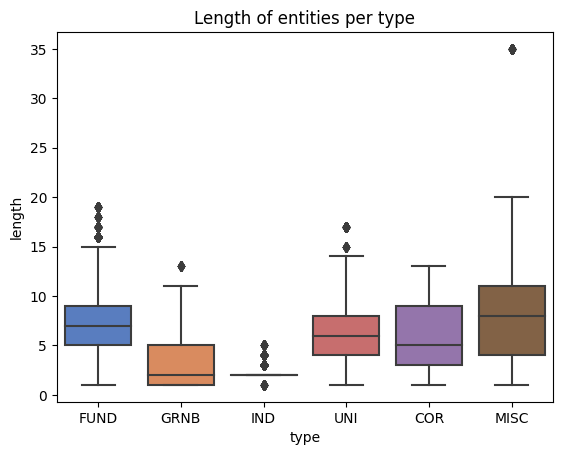

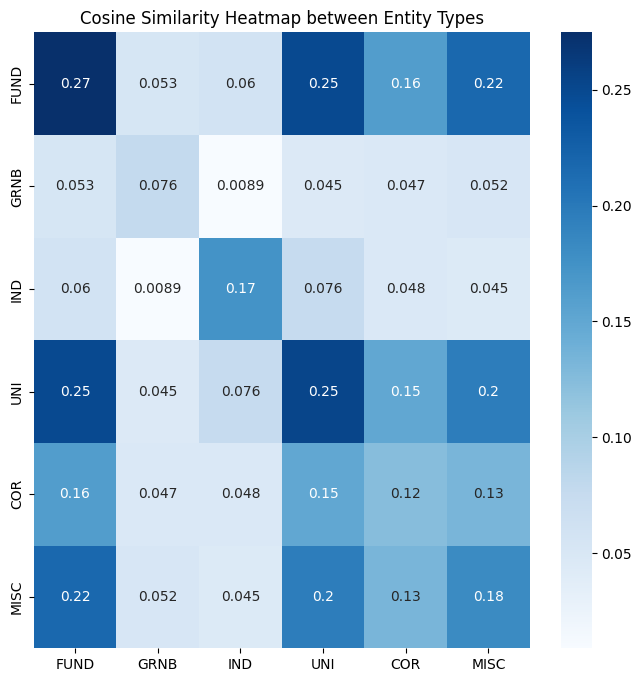

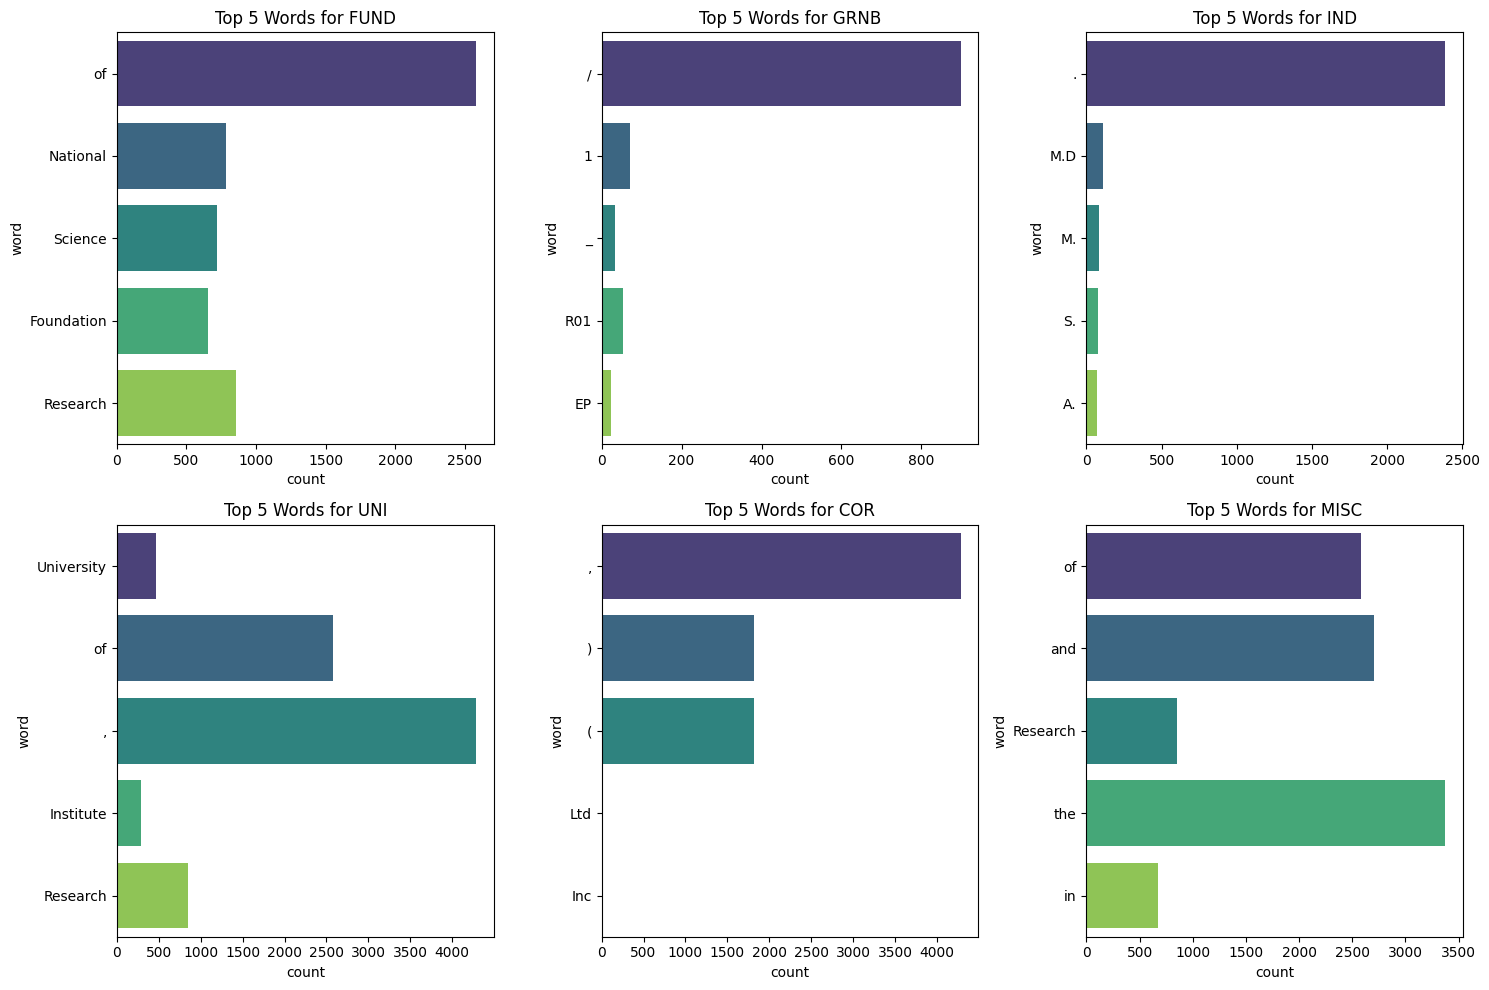

In [8]:
analyse(df)

## Results

* As for words distribution, there are roughly equal occurences between words that belongs to some entities and those that do not. This is good as we would not want to have entities recognition from vast amount of plain text.

* Three most popular entities are FUND, GRNB and IND. The remaining three are not that common. We'll see how it would affect classification.

* IND type has usually the smallest number of words. This is quite natural as it's mostly name and surname. MISC has on average the longest names (up to 35 words). Generally a typical entity consists of around up to 5 words.

* As for cosine similarity, we can see that within-group correlation is usually higher than between-groups. This is good when it comes to classification. However, the correlation is not so high. MISC has higher correlation with FUND than with itself. This may lead to misclassification.

* As for most frequent words, GRNB usually consists of /, _ or some number so it would be quite easy to identify this type. "of" is one of the most common words in 3 classes, similarily "," appears in both UNI and COR.